<a href="https://colab.research.google.com/github/Neo-glitch/kaggle_competitions/blob/main/Disaster_Tweets_Sentiment_Analysis(Hugging_Faces_Bert).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task is to predict if a given tweet is a real disaster or not**
if a real disaster predict a `1` else predict a `0`

* `text` column is a tweet
* `keyword` column is a keyword from that tweet (may be blank)
* `location` column is the location the tweet was sent from (may be blank)

In [1]:
!pip install kaggle
! pip install text_hammer  # helper library to help in cleaning text, although bert doesn't need much data cleaning

! pip install transformers
! pip install scipy sklearn

# A dependency of the preprocessing for BERT inputs
# ! pip install -q -U "tensorflow-text==2.8.*"

! pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
import tensorflow_text as text_tf
from official.nlp import optimization  # to create AdamW optimizer


from google.colab import files

import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

**Loading the Data**

In [3]:
files.upload()

# make a kaggle dir
!mkdir ~/.kaggle

# copies kaggle json to kaggle dir
!cp kaggle.json ~/.kaggle/

# gives permission
! chmod 600 ~/.kaggle/kaggle.json

# copied api command to get the kaggle dataset
!kaggle competitions download -c nlp-getting-started

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!mkdir tweets_sent_clf

!unzip nlp-getting-started -d tweets_sent_clf

mkdir: cannot create directory ‘tweets_sent_clf’: File exists
Archive:  nlp-getting-started.zip
replace tweets_sent_clf/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tweets_sent_clf/sample_submission.csv  
replace tweets_sent_clf/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tweets_sent_clf/test.csv  
replace tweets_sent_clf/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tweets_sent_clf/train.csv  


In [5]:
train_df = pd.read_csv("/content/tweets_sent_clf/train.csv", usecols = ["id", "text", "target"])  # selects just these cols to use in our dataframe
test_df = pd.read_csv("/content/tweets_sent_clf/test.csv", usecols = ["id", "text"])
sample_df = pd.read_csv("/content/tweets_sent_clf/sample_submission.csv")

In [6]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


**EDA**

In [9]:
train = train_df.copy(deep =True)

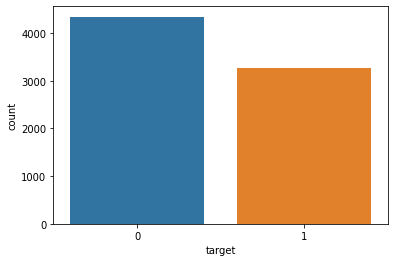

In [10]:
# data has more normal tweets than disaster tweets
sns.countplot(x = train["target"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


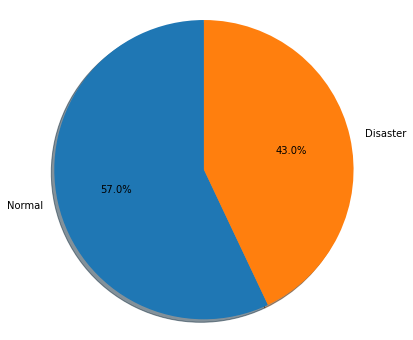

In [11]:
# viz same but with a pie chart this time
fig = plt.figure(figsize = (6, 6))
labels = "Normal", "Disaster"
sizes = [train["target"].value_counts()]

plt.pie(sizes, labels = labels, autopct='%0.1f%%',
        shadow=True, startangle=90)
plt.axis("equal")
plt.show();

**Data Preprocessing**

In [12]:
# seen that using stop wordding, stemming and other nlp preprocessing which is normal for nlp tasks go well
# when done together with Bert...so just do this lil preprocessing

def text_preprocessing(df, col_name):
  column = col_name

  # progress_apply is used to get a progress bar output via tqdm when running tasks
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
  return(df)

In [13]:
train = text_preprocessing(train, "text")

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

**Loading Bert Model**

In [28]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, \
                        AutoConfig  # used to set dropout for bert AutoModel

# bert_chkpt = "distilbert-base-uncased"
bert_chkpt = "bert-large-uncased"
batch_size = 32
num_labels = 2

# configuration = AutoConfig.from_pretrained(bert_chkpt)
# configuration.hidden_dropout_prob = 0.2
# configuration.attention_probs_dropout_prob = 0.2
# configuration.classifier_dropout = 0.2

id2label = {0: "Calm", 1: "Disaster"}
label2id = {val: key for key, val in id2label.items()}

tokenizer = AutoTokenizer.from_pretrained(bert_chkpt)
model = TFAutoModelForSequenceClassification.from_pretrained(bert_chkpt, num_labels = num_labels,
                                                             id2label=id2label, label2id=label2id
                                                             )

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# import gc

# del model
# gc.collect()

In [30]:
# test tokenizer to see result
tokenizer("This is my first trial on using a hugging face model for a machine learning task")

{'input_ids': [0, 713, 16, 127, 78, 1500, 15, 634, 10, 31164, 652, 1421, 13, 10, 3563, 2239, 3685, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**Convert Text data in form needed by Bert**

In [31]:
print("max len of tweets",max([len(x.split()) for x in train_df.text]))
max_length = 36

max len of tweets 31


In [32]:
x_train, x_val, y_train, y_val = train_test_split(train["text"], train["target"], test_size = 0.2, random_state = 42)

In [33]:
x_train_encodings = tokenizer(
    text = x_train.tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_encodings = tokenizer(
    text = x_val.tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True

)

In [34]:
x_train_encodings['input_ids'].shape

TensorShape([6090, 36])

In [35]:
x_val_encodings['attention_mask'].shape

TensorShape([1523, 36])

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encodings),
                                                    y_train)).batch(batch_size).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((dict(x_val_encodings),
                                                    y_val)).batch(batch_size).prefetch(AUTOTUNE)

**Build Model**

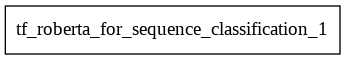

In [37]:
plot_model(model)

In [38]:
model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 354310144 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 1051650   
 ficationHead)                                                   
                                                                 
Total params: 355,361,794
Trainable params: 355,361,794
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs = 3

### special optimizer used to train transformers, only change if you have a reasonable reason to
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
# Set loss and metrics
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = ["accuracy"])

**Model Training**

In [ ]:
import datetime

#  Clear any logs from previous runs
! rm -rf ./logs/

# to log result on tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs
)

Epoch 1/3
 39/191 [=====>........................] - ETA: 1:58 - loss: 0.6702 - accuracy: 0.5865

In [69]:
model.evaluate(val_dataset)

48/48 [==============================] - 4s 84ms/step - loss: 0.4352 - accuracy: 0.8352


[0.43520787358283997, 0.8351936936378479]

**Model Prediction**

In [70]:
test = test_df.copy()
test = text_preprocessing(test, "text")

test_ids = test["id"]

test.drop(columns = ["id"], inplace =True)
test.head()

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

,text
0,just happened a terrible car crash
1,heard about earthquake is different cities sta...
2,there is a forest fire at spot pond geese are ...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills 28 in china and taiwan


In [71]:
x_test_encodings = tokenizer(
    text = test["text"].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True

)

x_test_encodings

{'input_ids': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[  101,  2074,  3047, ...,     0,     0,     0],
       [  101,  2657,  2055, ...,     0,     0,     0],
       [  101,  2045,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,     0,     0],
       [  101, 12669,  3314, ...,     0,     0,     0],
       [  101,  2103, 11253, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [72]:
x_test_encodings["input_ids"].shape, x_test_encodings["attention_mask"].shape

(TensorShape([3263, 36]), TensorShape([3263, 36]))

In [73]:
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encodings))).batch(16).prefetch(AUTOTUNE)

In [74]:
outputs = model.predict(test_dataset)

In [75]:
outputs.logits[4]

array([-1.8419392,  2.5139124], dtype=float32)

In [76]:
test["text"][4]

'typhoon soudelor kills 28 in china and taiwan'

In [77]:
predictions = np.argmax(outputs.logits, axis = -1)

In [78]:
submission = pd.DataFrame({
    "id": test_ids,
    "target" : predictions.reshape(-1)
})

submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [80]:
submission.to_csv("./submission.csv", index=False)

In [81]:
# submit to kaggle from google colab
! kaggle competitions submit -c nlp-getting-started -f submission.csv -m "using AutoSeq and roberta-Large"

100% 22.2k/22.2k [00:00<00:00, 30.2kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

## Another Way of Training Bert Model with more custom capabilities, useful for finetuning on smaller datasets

Offers option of choosing the classifier head to append, similar to Tensorflow_hub bert implementation

In [ ]:
from transfomers import AutoTokenizer, TFBertModel

bert_chkpt = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(bert_chkpt)
bert_model = TFBertModel.from_pretrained(bert_chkpt)

In [ ]:
# test tokenizer to see result
tokenizer("This is my first trial on using a hugging face model for a machine learning task")

**Convert Text data in form needed by Bert**

In [ ]:
print("max len of tweets",max([len(x.split()) for x in train_df.text]))
max_length = 36

max len of tweets 31


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train["text"], train["target"], test_size = 0.2)

In [ ]:
x_train_encoded = tokenizer(
    text = x_train.tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_encoded = tokenizer(
    text = x_val.tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True

)

In [ ]:
x_train_encoded['input_ids'].shape

TensorShape([6090, 36])

In [ ]:
x_val_encoded['attention_mask'].shape

TensorShape([6090, 36])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_encodings),
                                                    y_train)).batch(batch_size).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((dict(x_val_encodings),
                                                    y_val)).batch(batch_size).prefetch(AUTOTUNE)

**Build Model**

In [ ]:
input_ids = keras.layers.Input(shape=(max_length,), dtype =tf.int32, name = "input_ids")
input_mask = keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

embeddings = bert_model(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooled_output)

out = keras.layers.Dropout(0.1)(embeddings)
out = keras.layers.Dense(128, activation ="relu")(out)
y = keras.layers.Demse(1, activation = None)(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True  # set embeddings to be train, same as tf implementation

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             109482240   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 dropout_41 (Dropout)           (None, 768)          0           ['tf_bert_model[2][1]']    

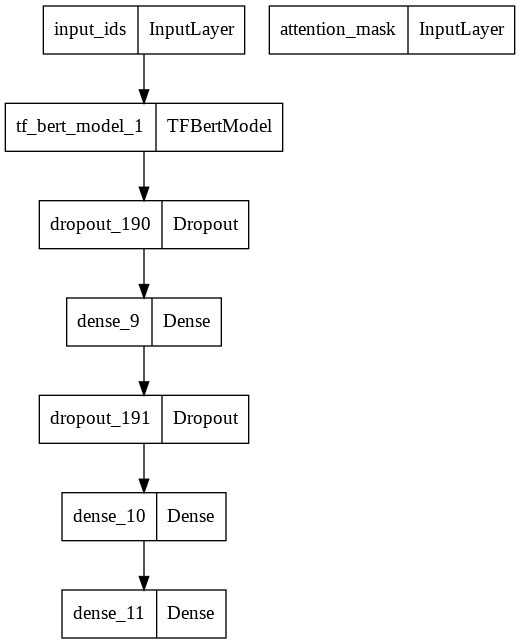

In [ ]:
plot_model(model)

In [ ]:
epochs = 3

### special optimizer used to train transformers, only change if you have a reasonable reason to
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# Set loss and metrics
loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metrics)

In [ ]:
# history = model.fit(
#     x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
#     y = y_train,
#     validation_data = ({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']}, y_val),

#   epochs= epochs
# )

import datetime

#  Clear any logs from previous runs
! rm -rf ./logs/

# to log result on tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs
)

**Model Prediction**

In [ ]:
test = test_df.copy()
test = text_preprocessing(test, "text")

test_ids = test["id"]

test.drop(columns = ["id"], inplace =True)
test.head()

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

,text
0,just happened a terrible car crash
1,heard about earthquake is different cities sta...
2,there is a forest fire at spot pond geese are ...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills 28 in china and taiwan


In [ ]:
x_test_encodings = tokenizer(
    text = test["text"].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True

)

x_test_encodings

{'input_ids': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[  101,  2074,  3047, ...,     0,     0,     0],
       [  101,  2657,  2055, ...,     0,     0,     0],
       [  101,  2045,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,     0,     0],
       [  101, 12669,  3314, ...,     0,     0,     0],
       [  101,  2103, 11253, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
x_test_encodings["input_ids"].shape, x_test_encodings["attention_mask"].shape

(TensorShape([3263, 36]), TensorShape([3263, 36]))

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((dict(x_test_encodings))).batch(16).prefetch(AUTOTUNE)

In [ ]:
outputs = model.predict(test_dataset)

In [ ]:
outputs.logits[4]

array([-1.8419392,  2.5139124], dtype=float32)

In [ ]:
test["text"][4]

'typhoon soudelor kills 28 in china and taiwan'

In [ ]:
predictions = np.argmax(outputs.logits, axis = -1)

In [ ]:
submission = pd.DataFrame({
    "id": test_ids,
    "target" : predictions.reshape(-1)
})

submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv("./submission.csv", index=False)

In [ ]:
# submit to kaggle from google colab
! kaggle competitions submit -c nlp-getting-started -f submission.csv -m "using AutoSeq and roberta-Large"

100% 22.2k/22.2k [00:00<00:00, 30.2kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets